In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer
from sklearn.feature_selection import SelectKBest

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

from sklearn.metrics import f1_score, confusion_matrix, auc, roc_curve, make_scorer, classification_report
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_predict

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier


from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imPip

import joblib

In [52]:
data0 = pd.read_csv("data.csv")

In [53]:
X_data = data0.drop(["Unnamed: 0", "SK_ID_CURR"], axis=1)
target = X_data.pop("TARGET")

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_data, target, test_size=0.2, random_state=85, stratify=target)

### Sampling

In [55]:
X_train_sample,_, y_train_sample, _ = train_test_split(X_train, y_train, test_size=0.5, random_state=85, stratify=y_train)

# Preprocessing

In [56]:
lgb = LGBMClassifier(random_state=85)

prepocessor = make_column_transformer((StandardScaler(), make_column_selector(dtype_include=np.number)),
                                      (OneHotEncoder(handle_unknown='ignore'), make_column_selector(dtype_exclude=np.number)))

In [57]:
prepocessor0 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), make_column_selector(dtype_include=np.number)),
        ('cat', OneHotEncoder(handle_unknown='ignore'), make_column_selector(dtype_exclude=np.number))])

In [58]:
def my_pipeline(classifier):
    
    my_pip = imPip([
    ("prepocessor", prepocessor),
    ("kbst", SelectKBest(k=100)),
    ("smote", SMOTE(n_jobs=-1)),
    ("classifier", classifier)])
    
    return my_pip

In [59]:
def plot_roc_curve(classifiers, X, y, n_splits=5, pip=True):

    kf = KFold(n_splits=n_splits, random_state=85, shuffle=True)
    plt.figure(figsize=(15,12))
    for name_clf, clf in classifiers.items():
        print(name_clf)
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 50)
        for i, (train, test) in enumerate(kf.split(X, y)):

            if pip:
                model = my_pipeline(clf)
            else:
                model = clf
            
            model.fit(X.iloc[train, :], y.iloc[train])
            

            y_pred_grd = model.predict_proba(X.iloc[test, :])[:, 1]
            fpr, tpr, _ = roc_curve(y.iloc[test], y_pred_grd)

            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            auc_ = auc(fpr, tpr)

            aucs.append(auc_)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = round(auc(mean_fpr, mean_tpr),2)
        plt.plot(mean_fpr, mean_tpr,
            label=name_clf + f'(AUC = {mean_auc})',
            lw=2,
            alpha=.8)

    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Taux faux positif')
    plt.ylabel('Taux vrai positif')
    plt.title('Courbe ROC')
    plt.legend(loc="lower right")
    plt.show()

## Fonction metric

In [60]:
def my_metric(y_true, y_pred, w_fn=-5, w_fp=-2, w_tp=5, w_tn=1): 
    
    matrix_conf = confusion_matrix(y_true, y_pred)
    
    # Nombre de True Negatifs
    tn = matrix_conf[0, 0]
    # Nombre de Faux Négatifs
    fn = matrix_conf[1, 0]
    # Nombre de Faux Positifs
    fp = matrix_conf[0, 1]
    # Nombre de True Positifs
    tp = matrix_conf[1, 1]
    
    # Gain 
    earn = tp*w_tp + tn*w_tn + fp*w_fp + fn*w_fn
    
    # Gain maximum
    max_earn = (fp + tn)*w_tn + (fn + tp)*w_tp
    
    # Gain minimum
    min_earn = (fp + tn)*w_fp + (fn + tp)*w_fn
    
    # Gain normalisé entre 0 et 1
    earn_norm = (earn - min_earn)/(max_earn - min_earn)
    
    return earn_norm

In [61]:
def func_build_params(param):
    new_param = {
        'kbst__k': range(5,110,10),
        'smote__k_neighbors': range(5,40,5),
        'smote__sampling_strategy':  np.arange(0.2, 1, 0.1)
    }
    for p , v in param.items():
        new_param[f"classifier__{p}"] =  v
    return new_param

In [62]:
resultas = joblib.load("resultat_final_AUC_13_7.joblib")
best_params = joblib.load("best_params00_13_7.joblib")
best_estimator = joblib.load("best_estimator00_13_7.joblib")

## Test Class_weight

In [63]:
my_pip_class_w = imPip([
    ("prepocessor", prepocessor),
    ("kbst", SelectKBest(k=95)),
    ("LGBM", LGBMClassifier(class_weight = {0: 1, 1: 1}))])

LGBM_cw


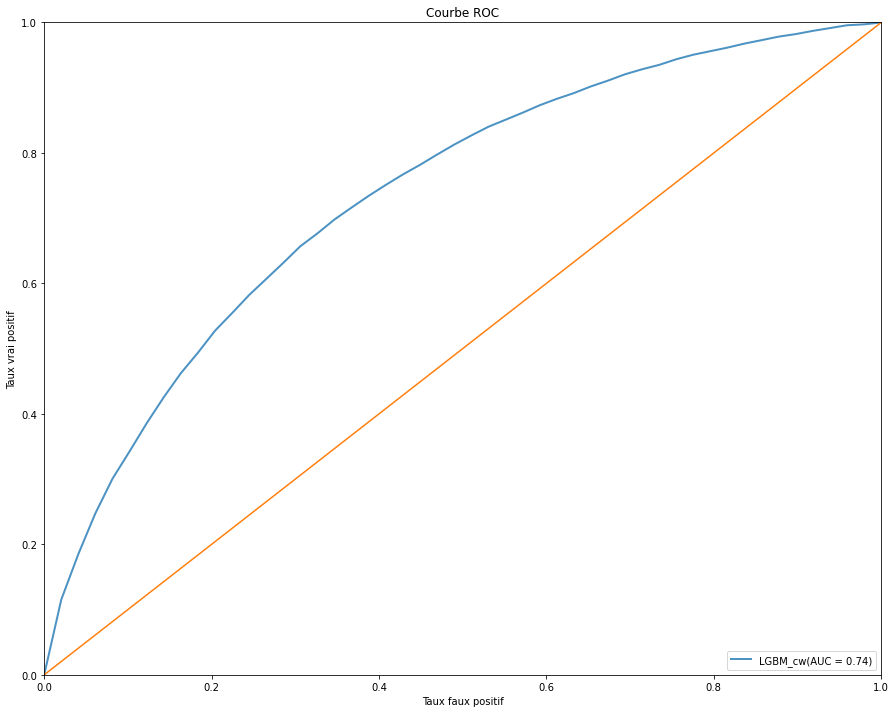

In [64]:
classifier_cw = {"LGBM_cw" : my_pip_class_w}
plot_roc_curve(classifier_cw, X_train_sample, y_train_sample, pip=False)

## Optimisation des params de LGBM

In [65]:
def evaluation_gridsearch_of_model(model_name, model, params_model, X, y):
    df = pd.DataFrame()
    
    skf = StratifiedKFold(n_splits=4)
    
    best_params = {}
    best_estimator = {}
    res_model = {}

    cv = skf.split(X, y)
    

    gridSearch = RandomizedSearchCV(estimator = model, param_distributions=params_model,n_iter=200, cv=cv, return_train_score=True, 
                                    scoring='roc_auc',
                                    n_jobs=-1
                                   )
    search = gridSearch.fit(X, y)

    best_estimator[model_name] = search.best_estimator_

    res = search.cv_results_
    res_model[model_name] = res

    index = np.where(res["rank_test_score"] == 1)[0]

    best_params[model_name] = res["params"][index[0]]

    df.loc[0, "models"] = model_name

    df.loc[0, "AUC_train"] = round(res["mean_train_score"][index][0], 4)
    df.loc[0, "AUC_test"] = round(res["mean_test_score"][index][0], 4)

        
        
    return df, best_params, best_estimator, res_model

In [66]:
model_lgbm = my_pipeline(LGBMClassifier())

In [67]:
param_LGBM_1 = {
    'smote__sampling_strategy': [0.45, 0.5, 0.55],
    'smote__k_neighbors': [11,13,14,15,16,17,19],
    'kbst__k': [92,93,94,95,96,97],
    'classifier__n_estimators': [95,96,97,98,99,100,101,102,103],
    'classifier__learning_rate': [0.05,0.07,0.08,0.1, 0.15,0.18],
    'classifier__num_leaves' : [25,27,29,31,33,35],
    'classifier__objective' : ['regression', 'binary'],
    'classifier__reg_lambda' : [0, 10, 15, 35, 40]
}


In [68]:
param_LGBM_2 = {
    'smote__sampling_strategy': [0.53, 0.54, 0.55,0.56,0.57],
    'smote__k_neighbors': [14],
    'kbst__k': [94],
    'classifier__n_estimators': [102],
    'classifier__learning_rate': [0.13,0.14, 0.15,0.16,0.17],
    'classifier__num_leaves' : [28,29,30,31],
    'classifier__objective' : ['binary'],
    'classifier__reg_lambda' : [11, 12, 13, 14,15,16,17,20]
}

In [ ]:
%%time
df01, best_params01, best_estimator01, res01 = evaluation_gridsearch_of_model("lgbm", model_lgbm, param_LGBM_1, X_train_sample, y_train_sample)

In [ ]:
%%time
df02, best_params02, best_estimator02, res02 = evaluation_gridsearch_of_model("lgbm", model_lgbm, param_LGBM_2, X_train_sample, y_train_sample)

In [ ]:
best_params01

In [ ]:
best_params02

In [72]:
f_model = my_pipeline(LGBMClassifier(n_jobs=-1))
f_params = {'smote__sampling_strategy': 0.57,
  'smote__k_neighbors': 14,
  'kbst__k': 94,
  'classifier__reg_lambda': 12,
  'classifier__objective': 'binary',
  'classifier__num_leaves': 30,
  'classifier__n_estimators': 102,
  'classifier__learning_rate': 0.14}

In [73]:
f_model.set_params(**f_params)

Pipeline(steps=[('prepocessor',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f3e18343a00>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f3dad4cd700>)])),
                ('kbst', SelectKBest(k=94)),
                ('smote',
                 SMOTE(k_neighbors=14, n_jobs=-1, sampling_strategy=0.57)),
                ('classifier',
                 LGBMClassifier(learning_rate=0.14, n_estimators=102,
                                num_leaves=30, objective='binary',
                                reg_lambda=12))])

In [74]:
%%time
y_proba = cross_val_predict(f_model,
                                    X_train_sample,
                                    y_train_sample,
                                    method='predict_proba',
                                    cv=5,
                           n_jobs=-1)

CPU times: user 447 ms, sys: 104 ms, total: 551 ms
Wall time: 26.9 s


In [75]:
df_y_proba = pd.DataFrame(y_proba, columns=[0,1])

In [76]:
df_pred = pd.DataFrame()
thresholds = []
metrics_constum = []
for threshold in [x/20 for x in range(1, 20)]:
    new_pred = df_y_proba[1].apply(lambda x: 1 if x>threshold else 0)
    df_pred[f"threshold_{threshold}"] = new_pred
    thresholds.append(threshold)
    metrics_constum.append(my_metric(y_train_sample,new_pred))
    

In [77]:
df_pred.head()

,threshold_0.05,threshold_0.1,threshold_0.15,threshold_0.2,threshold_0.25,threshold_0.3,threshold_0.35,threshold_0.4,threshold_0.45,threshold_0.5,threshold_0.55,threshold_0.6,threshold_0.65,threshold_0.7,threshold_0.75,threshold_0.8,threshold_0.85,threshold_0.9,threshold_0.95
0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


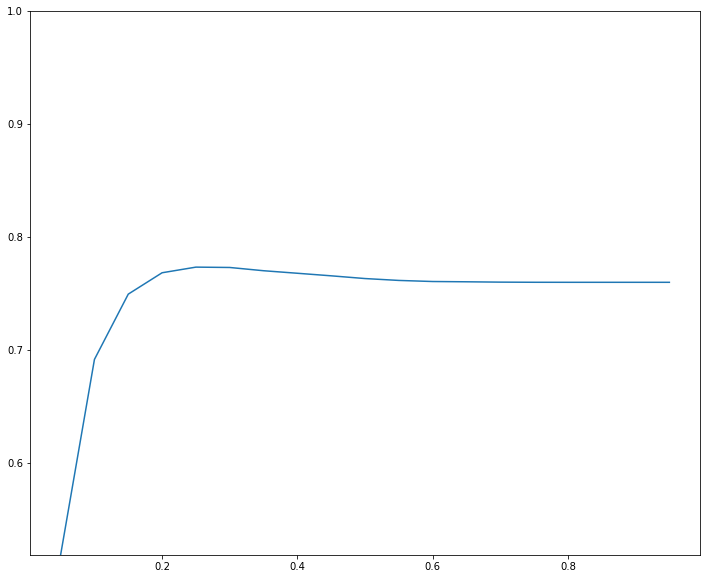

In [78]:
plt.figure(figsize=(12,10))
plt.plot(thresholds,metrics_constum)
plt.ylim((min(metrics_constum),1))
plt.show()

In [79]:
best_threshold = thresholds[metrics_constum.index(max(metrics_constum))]

In [80]:
confusion_matrix(y_train_sample, df_pred[f'threshold_{best_threshold}'])

array([[87823,  4290],
       [ 6958,  1776]])

In [81]:
f_model.named_steps

{'prepocessor': ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f3e18343a00>),
                                 ('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore'),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f3dad4cd700>)]),
 'kbst': SelectKBest(k=94),
 'smote': SMOTE(k_neighbors=14, n_jobs=-1, sampling_strategy=0.57),
 'classifier': LGBMClassifier(learning_rate=0.14, n_estimators=102, num_leaves=30,
                objective='binary', reg_lambda=12)}

In [82]:
f_model.fit(X_train_sample, y_train_sample)

Pipeline(steps=[('prepocessor',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f3e18343a00>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f3dad4cd700>)])),
                ('kbst', SelectKBest(k=94)),
                ('smote',
                 SMOTE(k_neighbors=14, n_jobs=-1, sampling_strategy=0.57)),
                ('classifier',
                 LGBMClassifier(learning_rate=0.14, n_estimators=102,
                                num_leaves=30, objective='binary',
                                reg_lambda=12))])

In [83]:
list_num_features = list(f_model['prepocessor'].transformers_[0][2])
list_cat_features = list(f_model['prepocessor'].transformers_[1][1].get_feature_names(f_model['prepocessor'].transformers_[1][2]))

In [84]:
list_of_features = list_num_features + list_cat_features

In [85]:
mask_kbst = f_model['kbst'].get_support()
scores_kbst = f_model['kbst'].scores_

In [86]:
my_data = {"features":list_of_features,
           "scores" : scores_kbst,
          "mask": mask_kbst}

my_df = pd.DataFrame(my_data)

In [87]:
my_df = my_df.sort_values(by=["scores"],ascending=False)

In [88]:
# nom des colonnes selectionné dans Kbest

features = my_df[mask_kbst]["features"].values

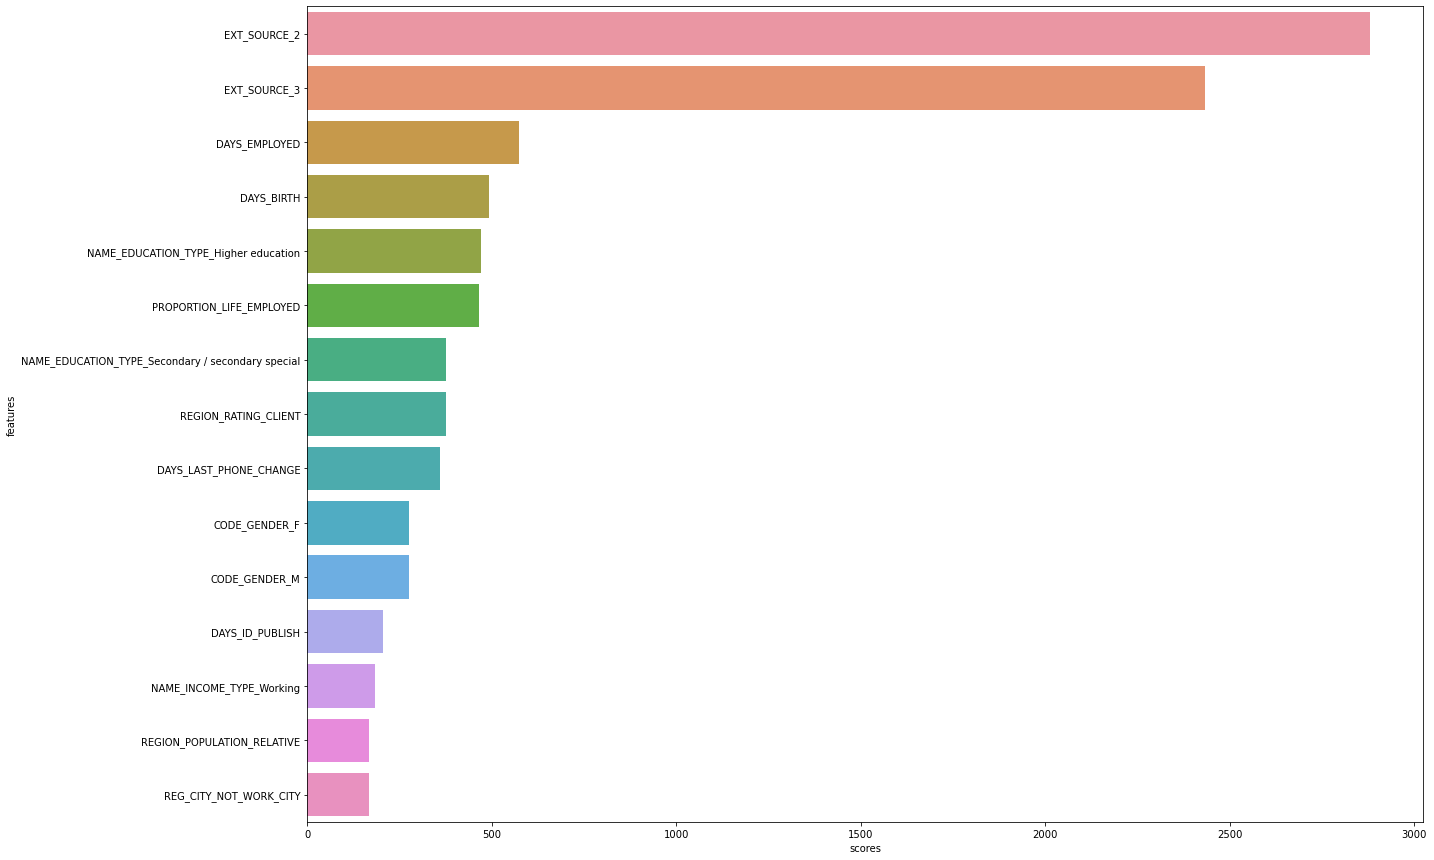

In [89]:
plt.figure(figsize=(20,15))
sns.barplot(data=my_df.iloc[:15,:],x="scores", y="features", orient="h")
plt.show()

In [90]:
import shap

In [91]:
transf = imPip([("prepocessor", prepocessor),
                ("kbst", SelectKBest()),
                ("smote", SMOTE(n_jobs=-1))]
)

In [92]:
transf.set_params(**{'smote__sampling_strategy': 0.57,
 'smote__k_neighbors': 14,
 'kbst__k': 94})

Pipeline(steps=[('prepocessor',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f3e18343a00>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f3dad4cd700>)])),
                ('kbst', SelectKBest(k=94)),
                ('smote',
                 SMOTE(k_neighbors=14, n_jobs=-1, sampling_strategy=0.57))])

In [93]:
X00, y00 = transf.fit_resample(X_train_sample, y_train_sample)

In [136]:
X00_test, y00_test = transf.fit_resample(X_test, y_test)

In [94]:
X_sample_trans = pd.DataFrame(X00.toarray(), columns=features)

In [95]:
X_sample_trans.shape, y_train_sample.shape

((144617, 94), (100847,))

In [96]:
my_model = LGBMClassifier().set_params(**{'reg_lambda': 12,
 'objective': 'binary',
 'num_leaves': 30,
 'n_estimators': 102,
 'learning_rate': 0.14})

In [97]:
my_model.fit(X00, y00)

LGBMClassifier(learning_rate=0.14, n_estimators=102, num_leaves=30,
               objective='binary', reg_lambda=12)

In [153]:
%%time
explainer = shap.TreeExplainer(my_model)

CPU times: user 139 ms, sys: 0 ns, total: 139 ms
Wall time: 138 ms


In [ ]:
shap_values = explainer.shap_values(X_sample_trans)
expected_value = explainer.expected_value

### Echantillon pour Shap 

In [156]:
N = 1500
X_shap = X00.toarray()
y_shap = y00

In [157]:
random_samp = np.random.choice(X_shap.shape[0], N)
X_shap_sample = X_shap[random_samp]
y_shap_sample = y_shap[random_samp]

In [158]:
my_model.fit(X_shap_sample, y_shap_sample)

LGBMClassifier(learning_rate=0.14, n_estimators=102, num_leaves=30,
               objective='binary', reg_lambda=12)

In [159]:
%%time
tree_explainer = shap.TreeExplainer(my_model)

CPU times: user 165 ms, sys: 7.98 ms, total: 173 ms
Wall time: 175 ms


In [160]:
df_shap_sample = pd.DataFrame(X_shap_sample, columns=features)

In [161]:
tree_shap_values = tree_explainer.shap_values(X_shap_sample)
tree_expected_value = tree_explainer.expected_value

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [106]:
df_xshap = pd.DataFrame(X_shap, columns=features)

In [107]:
"""explainer = shap.Explainer(my_model, X_shap)
shap_values = explainer(df_xshap,check_additivity=False)"""

'explainer = shap.Explainer(my_model, X_shap)\nshap_values = explainer(df_xshap,check_additivity=False)'

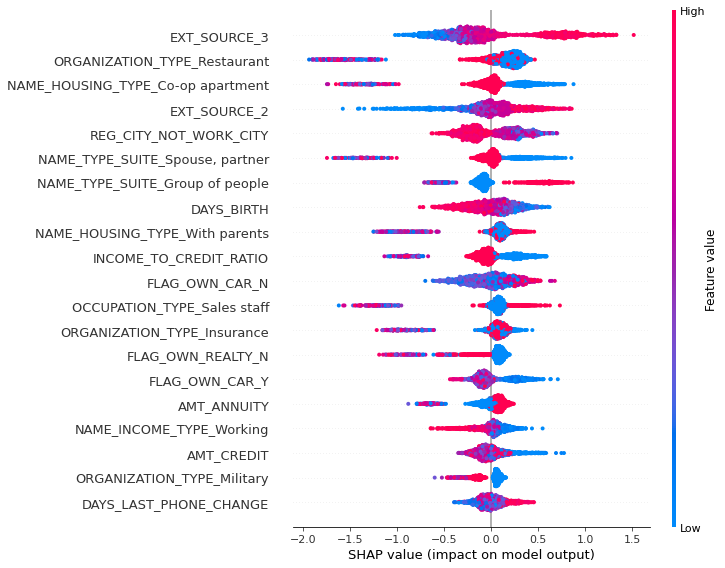

In [162]:
shap.summary_plot(tree_shap_values[0], df_shap_sample)

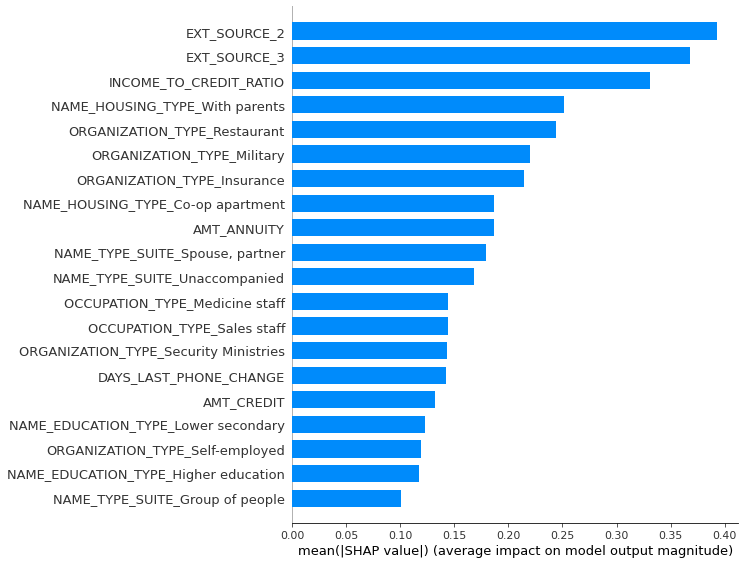

In [128]:
shap.summary_plot(tree_shap_values[1], df_shap_sample, plot_type="bar")

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


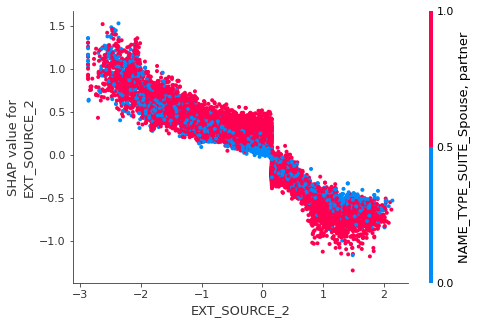

In [123]:
shap.dependence_plot("EXT_SOURCE_2", tree_shap_values[1], df_shap_sample)

In [179]:
tree_shap_values[0]

(1500, 94)

In [165]:
len(tree_shap_values[0])

1500

In [112]:
# Initialize your Jupyter notebook with initjs(), otherwise you will get an error message.
shap.initjs()

# Write in a function
def shap_plot(j):
    explainerModel = shap.TreeExplainer(model)
    shap_values_Model = explainerModel.shap_values(S)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], S.iloc[[j]])
    return(p)

In [142]:
X_output.toarray().shape

(72309, 94)

In [133]:
np.arange(1,2330,50)

array([   1,   51,  101,  151,  201,  251,  301,  351,  401,  451,  501,
        551,  601,  651,  701,  751,  801,  851,  901,  951, 1001, 1051,
       1101, 1151, 1201, 1251, 1301, 1351, 1401, 1451, 1501, 1551, 1601,
       1651, 1701, 1751, 1801, 1851, 1901, 1951, 2001, 2051, 2101, 2151,
       2201, 2251, 2301])

In [144]:
import xgboost

In [202]:
shap.initjs()

# train XGBoost model
X,y = shap.datasets.boston()
bst = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)

# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X)

In [209]:
explainer.expected_value

14.230186

In [212]:
shap.initjs()

In [234]:
shap.force_plot(tree_explainer.expected_value[1],
                              tree_shap_values[1][100,:],
                              df_shap_sample.iloc[100,:])

In [232]:
df_shap_sample

,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_EMPLOYED,DAYS_BIRTH,NAME_EDUCATION_TYPE_Higher education,PROPORTION_LIFE_EMPLOYED,NAME_EDUCATION_TYPE_Secondary / secondary special,REGION_RATING_CLIENT,DAYS_LAST_PHONE_CHANGE,CODE_GENDER_F,...,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Cleaning,NAME_TYPE_SUITE_Group of people,ORGANIZATION_TYPE_Telecom,NAME_TYPE_SUITE_Children,"NAME_TYPE_SUITE_Spouse, partner",WEEKDAY_APPR_PROCESS_START_TUESDAY,ORGANIZATION_TYPE_Industry,ORGANIZATION_TYPE_Mobile,NAME_HOUSING_TYPE_Co-op apartment
0,0.852222,0.046349,0.667190,-0.540738,0.072876,-0.364779,-0.621920,-0.623791,0.829062,-0.087660,...,0.0,0.0,0.000000,0.020211,0.0,0.979789,0.020211,0.0,0.0,0.979789
1,-0.540271,0.839079,-0.654646,0.708136,-0.877513,-0.776967,1.607923,-0.623791,0.544451,-0.087660,...,0.0,0.0,0.000000,0.000000,0.0,1.000000,0.000000,0.0,0.0,1.000000
2,0.399809,-0.384432,0.667190,-1.811498,0.269967,-0.571505,-0.621920,-0.623791,-0.667474,1.861685,...,0.0,0.0,0.000000,0.000000,0.0,1.000000,0.000000,0.0,0.0,1.000000
3,0.158209,-0.079211,-0.654646,1.171198,-0.877513,-0.366043,-0.621920,-0.623791,1.150414,-0.087660,...,0.0,0.0,1.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,1.000000
4,0.158209,-0.117075,0.667190,-0.890211,-0.364576,1.688580,-0.621920,1.603101,-0.667474,-0.087660,...,0.0,0.0,1.000000,0.000000,0.0,0.000000,1.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,1.728851,-0.694740,-0.654646,-2.506695,0.190065,-0.571505,-0.621920,-0.623791,1.756376,-0.087660,...,0.0,0.0,0.000000,0.000000,0.0,1.000000,0.000000,0.0,0.0,1.000000
1496,-1.298370,0.628549,-0.654646,0.044375,-0.839781,0.044882,-0.621920,-0.623791,0.241470,1.861685,...,0.0,0.0,0.000000,0.000000,0.0,1.000000,1.000000,0.0,0.0,0.000000
1497,0.168577,0.509043,-0.654646,-0.909107,-0.592878,-0.711480,0.137643,1.603101,-0.054874,-0.087660,...,0.0,0.0,0.000000,0.000000,0.0,1.000000,0.000000,0.0,0.0,1.000000
1498,0.498769,-0.551833,1.989027,1.174825,-1.024932,-0.160580,1.607923,1.603101,-0.667474,-0.087660,...,0.0,0.0,0.000000,0.000000,0.0,1.000000,0.000000,1.0,0.0,0.000000


In [216]:
X_train_sample

[array([[ 0.50676957, -0.26548357,  0.123894  , ...,  0.        ,
          0.        , -1.48788968],
        [-0.03137761,  0.87971946, -0.00615621, ...,  0.        ,
          0.        , -0.03083379],
        [ 0.18776606, -0.16148293,  0.19035703, ...,  0.        ,
          0.        , -0.02666345],
        ...,
        [-0.05704728, -0.24784722, -0.05217068, ...,  0.        ,
          0.        ,  0.01187851],
        [ 0.15654884, -0.14409177, -0.21406083, ...,  0.        ,
          0.        ,  0.3119164 ],
        [-0.06392383, -0.75421921, -0.09077148, ...,  0.        ,
          0.        , -0.10446144]]),
 array([[-0.50676957,  0.26548357, -0.123894  , ...,  0.        ,
          0.        ,  1.48788968],
        [ 0.03137761, -0.87971946,  0.00615621, ...,  0.        ,
          0.        ,  0.03083379],
        [-0.18776606,  0.16148293, -0.19035703, ...,  0.        ,
          0.        ,  0.02666345],
        ...,
        [ 0.05704728,  0.24784722,  0.05217068, ...,  

In [184]:
df_shap_sample.iloc[0,:]

EXT_SOURCE_2                            0.852222
EXT_SOURCE_3                            0.046349
DAYS_EMPLOYED                           0.667190
DAYS_BIRTH                             -0.540738
NAME_EDUCATION_TYPE_Higher education    0.072876
                                          ...   
NAME_TYPE_SUITE_Spouse, partner         0.979789
WEEKDAY_APPR_PROCESS_START_TUESDAY      0.020211
ORGANIZATION_TYPE_Industry              0.000000
ORGANIZATION_TYPE_Mobile                0.000000
NAME_HOUSING_TYPE_Co-op apartment       0.979789
Name: 0, Length: 94, dtype: float64

In [194]:
df_shap_sample.iloc[0,:]

EXT_SOURCE_2                            0.852222
EXT_SOURCE_3                            0.046349
DAYS_EMPLOYED                           0.667190
DAYS_BIRTH                             -0.540738
NAME_EDUCATION_TYPE_Higher education    0.072876
                                          ...   
NAME_TYPE_SUITE_Spouse, partner         0.979789
WEEKDAY_APPR_PROCESS_START_TUESDAY      0.020211
ORGANIZATION_TYPE_Industry              0.000000
ORGANIZATION_TYPE_Mobile                0.000000
NAME_HOUSING_TYPE_Co-op apartment       0.979789
Name: 0, Length: 94, dtype: float64

In [231]:
X_train_sample

,OCCUPATION_TYPE,EXT_SOURCE_3,NAME_TYPE_SUITE,EXT_SOURCE_2,CNT_CHILDREN,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,DAYS_LAST_PHONE_CHANGE,FLAG_OWN_REALTY,...,DAYS_BIRTH,REGION_POPULATION_RELATIVE,NAME_HOUSING_TYPE,NAME_FAMILY_STATUS,NAME_EDUCATION_TYPE,NAME_INCOME_TYPE,AMT_ANNUITY,PROPORTION_LIFE_EMPLOYED,INCOME_TO_CREDIT_RATIO,INCOME_TO_ANNUITY_RATIO
98917,High skill tech staff,0.210350,Unaccompanied,0.313362,0,Cash loans,M,Y,-22.0,Y,...,-10213,0.018801,House / apartment,Married,Incomplete higher,Working,62073.0,0.055028,0.222387,3.479774
224003,Drivers,0.612704,Unaccompanied,0.159436,0,Cash loans,M,N,-1456.0,Y,...,-19285,0.007305,House / apartment,Married,Secondary / secondary special,Commercial associate,42520.5,0.394141,0.085609,2.645783
188414,Core staff,0.424130,Unaccompanied,0.636081,1,Cash loans,F,N,-263.0,N,...,-13108,0.028663,House / apartment,Separated,Higher education,Working,12204.0,0.155859,0.600000,11.061947
50654,Core staff,0.744932,Unaccompanied,0.713895,0,Cash loans,F,N,-1936.0,Y,...,-15774,0.026392,House / apartment,Single / not married,Higher education,Commercial associate,36094.5,0.101623,0.466667,8.727091
158144,Managers,0.535276,Unaccompanied,0.609609,0,Cash loans,F,Y,-3240.0,N,...,-18046,0.028663,House / apartment,Married,Secondary / secondary special,State servant,28417.5,0.415826,0.232558,7.917656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93466,Drivers,0.576209,Unaccompanied,0.713126,0,Cash loans,M,Y,-458.0,Y,...,-17785,0.035792,House / apartment,Married,Secondary / secondary special,Working,25195.5,0.046725,0.173901,4.465083
246658,High skill tech staff,0.535276,Family,0.288800,2,Cash loans,M,N,-1807.0,Y,...,-13803,0.009630,House / apartment,Married,Secondary / secondary special,Working,38155.5,0.225603,0.172414,5.896922
80896,Accountants,0.144648,Unaccompanied,0.074261,2,Revolving loans,F,Y,0.0,Y,...,-13253,0.026392,House / apartment,Married,Higher education,Working,6750.0,0.264468,0.500000,10.000000
213778,Private service staff,0.535276,Unaccompanied,0.623032,0,Cash loans,F,N,-863.0,N,...,-18704,0.026392,House / apartment,Widow,Secondary / secondary special,Commercial associate,21100.5,0.065441,0.572727,13.435701
